## CNN model for Oa06 reflectance band for sea surface colour dataset from Sentinel 3a
### Author: Smita Chakraborty, RISE

In [1]:
##libraries for ML tasks
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LSTM, TimeDistributed, Reshape
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import datetime
#from utils import LSTMClassifier, xLSTMClassifier
import tifffile as tiff
from tensordict import TensorDict
import pandas as pd

## libraries for s3 bucket connection: read input and write output
import sys
sys.path.append('../.')
import boto3
from dotenv import load_dotenv
import os
from utils import boto3_connect
from itertools import product
import rasterio as rio
from rasterio import windows
from io import BytesIO

2024-10-16 13:39:17.412758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:39:17.431588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 13:39:17.437249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 13:39:17.451402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 13:39:18.426547: W tensorflow/compiler/tf2

In [2]:

#read tiff files
def read_tiff(img, outx):

    # Convert to grayscale if it's not already
    #if img.mode != 'L':
    #   img = img.convert('L')

    # Convert to numpy array
    #img_array = np.array(img)
    
    #rasterio to read pixel values, 1000 x 1000 array
    pix_val = img.read(1) 
    
    #returns date
    #so im.tags()["date"]
    
    #skip nan tiffs
    if np.all(np.isnan(pix_val)) is False:

        # Normalize to [0, 1] range
        norm = (pix_val - np.nanmin(pix_val))/(np.nanmax(pix_val) - np.nanmin(pix_val))
        #img_array = img_array.astype(np.float32) / 255 #change to x-min/max-min

        # adds a channel dimension to the array(shape becomes [1, height, width, norm_pix_val]).
        #need to add norm
        #img_array = np.expand_dims(pix_val, axis=0)

        # Convert to PyTorch tensor
        #tensor = torch.from_numpy(pix_val) #img_array

        # Adds a batch dimension to the tensor, making its shape [1, 1, height, width]
        #tensor = tensor.unsqueeze(0)

        outx.append(norm)
    
    return outx
        #print(outx)


In [3]:
## login credentials to DEDL platform from the .env file in parent directory
load_dotenv()
USERNAME=os.getenv('DEDL_USERNAME')
PASSWORD=os.getenv('DEDL_PASSWORD')
ACCESS_KEY=os.getenv('S3_ACCESS_KEY')
SECRET_KEY=os.getenv('S3_SECRET_KEY')

s3=boto3_connect(ACCESS_KEY, SECRET_KEY)

s3buc = s3.Bucket('algaestorm')

In [4]:
#for obj in s3buc.objects.filter(Prefix="eodata/split_img/"):
#    print(obj.key)

In [5]:
#creates a list of tensors for the input conv2d layer
outx = []
#access Oa06 band for 
for obj in s3buc.objects.filter(Prefix="eodata/split_img_Oa06/S3A_OL_2_WFR____20190602T084749_20190602T085049_20190603T201514_0179_045_221_1980_MAR_O_NT_002.SEN3/"):     
    #loops through all tiffs in 1 day
    ##connecting to s3 bucket repository 
    #s3obj=s3.Object(bucket_name='algaestorm',key='https://cloud.central.data.destination-earth.eu/project/containers/container/algaestorm/eodata/Sentinel-3/OLCI/OL_2_WFR/2019/04/')
    body = obj.get()['Body'].read()
    filelike=BytesIO(body)
    with rio.open(filelike, mode='r') as im:

        date=im.tags()["date"] 
        
        #check dimension of the file
        x_dim = im.width
        y_dim = im.height
        
        val = im.read(1)
        
        chk = ~np.all(np.isnan(val))
        #print(np.all(np.isnan(val)), chk)
        
        if (x_dim, y_dim) == (1000, 1000) and chk:
            
            # Normalize to [0, 1] range
            norm = (val - np.nanmin(val))/(np.nanmax(val) - np.nanmin(val))
            #read tiff files and builds a list of tensors
            #outx = read_tiff(im, outx)
            #print(norm, x_dim, y_dim)
            tensor = torch.from_numpy(norm) 
            
            # Adds a batch dimension to the tensor, making its shape [1, 1, height, width]
            #tensor = tensor.unsqueeze(0)
            
            # Adds a channel dimension to the tensor, making its shape [1, height, width, 1]
            tensor = tensor.unsqueeze(2)
            
            outx.append(tensor)
                                                                                                                                                                            

#print(outx)

In [6]:
#create a tensor of the list of tensors
result = torch.stack(outx, 0)

In [7]:
#check the shape of the output tensor, should have the shape:
# (batch size, img_height, img_width, channels) as conv2d accepts 4D tensor
tf.shape(result)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  12, 1000, 1000,    1], dtype=int32)>

In [8]:
#creates a list of tensors for the input conv2d layer for a second date
outx_2 = []

for obj in s3buc.objects.filter(Prefix="eodata/split_img_Oa06/S3A_OL_2_WFR____20190603T082138_20190603T082438_20190604T171448_0179_045_235_1980_MAR_O_NT_002.SEN3/"): #S3A_OL_2_WFR____20190603T082138_20190603T082438_20190604T171448_0179_045_235_1980_MAR_O_NT_002.SEN3/
    #loops through all tiffs in 1 day
    ##connecting to s3 bucket repository 
    #s3obj=s3.Object(bucket_name='algaestorm',key='https://cloud.central.data.destination-earth.eu/project/containers/container/algaestorm/eodata/Sentinel-3/OLCI/OL_2_WFR/2019/04/')
    body = obj.get()['Body'].read()
    filelike=BytesIO(body)
    with rio.open(filelike, mode='r') as im:

        date=im.tags()["date"] 
        
        #check dimension of the file
        x_dim = im.width
        y_dim = im.height
        
        val = im.read(1)
        
        chk = ~np.all(np.isnan(val))
        #print(np.all(np.isnan(val)), chk)
        
        if (x_dim, y_dim) == (1000, 1000) and chk:
            
            # Normalize to [0, 1] range
            norm = (val - np.nanmin(val))/(np.nanmax(val) - np.nanmin(val))
            #read tiff files and builds a list of tensors
            #outx = read_tiff(im, outx)
            #print(norm, x_dim, y_dim)
            tensor = torch.from_numpy(norm) 
            
            # Adds a batch dimension to the tensor, making its shape [1, 1, height, width]
            #tensor = tensor.unsqueeze(0)
            
            # Adds a batch dimension to the tensor, making its shape [1, 1, height, width]
            tensor = tensor.unsqueeze(2)
            
            outx_2.append(tensor)
                                                                                                                                                                            

#print(outx_2)

In [9]:
#create a tensor of the list of tensors
result2 = torch.stack(outx_2, 0)

In [10]:
#check the shape of the output tensor, should have the shape:
# (batch size, img_height, img_width, channels) as conv2d accepts 4D tensor
tf.shape(result2)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([   6, 1000, 1000,    1], dtype=int32)>

In [11]:
 #Define the model with a Dense layer
    #rescaling and conv2D as this exceeds memory
#model = tf.keras.Sequential([
 #   layers.Flatten(input_shape=result.shape),
 #   layers.Dense(units=1000000, activation='linear')
#])


In [12]:
# replace nan values with zero for now, 
# nan hinders the model from learning even if some pixel values are non-zero
def replace_nan_with_zero(tensor):
    return tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)

result = replace_nan_with_zero(result)
result2 = replace_nan_with_zero(result2)

In [13]:
# Slice the tensor to reduce batch size
reduced_result = result[:6, :, :, :]

# Split the tensor into two parts along the batch dimension
#part1, part2 = tf.split(pred_result, num_or_size_splits=2, axis=0)

In [14]:
#the main conv2D layers
img_height= 1000
img_width= 1000
encoder = tf.keras.Sequential([
        #layers.Rescaling(1./1000, input_shape=(img_height, img_width, 1)), #no. of channel is 1
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'), #16 filters, 3 x 3 kernel size
        layers.Conv2D(1, (1, 1), activation='relu', padding='same'), #1 filter, 1 x 1 kernel size
        #layers.MaxPooling2D((2, 2), padding='same') #output size is (img_height/2, img_width/2, 64)
    ])

In [15]:
# Compile the model
encoder.compile(optimizer='adam', loss='mean_squared_error')

print(reduced_result.shape)

# Predict pixel values
predicted_values = encoder.predict(reduced_result)

#print(predicted_values)

#prints shape of predicted tensor
print(predicted_values.shape)

(6, 1000, 1000, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
(6, 1000, 1000, 1)


In [16]:
#creates a new list of tensors from a new date
pred = []

for obj in s3buc.objects.filter(Prefix="eodata/split_img_Oa06/S3A_OL_2_WFR____20190605T091015_20190605T091315_20190606T200225_0179_045_264_1980_MAR_O_NT_002.SEN3/"): #S3A_OL_2_WFR____20190603T082138_20190603T082438_20190604T171448_0179_045_235_1980_MAR_O_NT_002.SEN3/
    #loops through all tiffs in 1 day
    ##connecting to s3 bucket repository 
    #s3obj=s3.Object(bucket_name='algaestorm',key='https://cloud.central.data.destination-earth.eu/project/containers/container/algaestorm/eodata/Sentinel-3/OLCI/OL_2_WFR/2019/04/')
    body = obj.get()['Body'].read()
    filelike=BytesIO(body)
    with rio.open(filelike, mode='r') as im:

        date=im.tags()["date"] 
        
        #check dimension of the file
        x_dim = im.width
        y_dim = im.height
        
        val = im.read(1)
        
        chk = ~np.all(np.isnan(val))
        #print(np.all(np.isnan(val)), chk)
        print(np.nanmin(val))
        
        if (x_dim, y_dim) == (1000, 1000) and chk:
            
            # Normalize to [0, 1] range
            p_norm = (val - np.nanmin(val))/(np.nanmax(val) - np.nanmin(val))
            #read tiff files and builds a list of tensors
            #outx = read_tiff(im, outx)
            #print(norm, x_dim, y_dim)
            p_tensor = torch.from_numpy(p_norm) 
            
            # Adds a batch dimension to the tensor, making its shape [1, 1, height, width]
            #tensor = tensor.unsqueeze(0)
            
            # Adds a channel dimension to the tensor, making its shape [1, height, width, 1]
            p_tensor = p_tensor.unsqueeze(2)
            
            pred.append(p_tensor)
                                                                                                                                                                            

#print(pred)

nan


/tmp/ipykernel_57743/2393515261.py:22: RuntimeWarning: All-NaN slice encountered
  print(np.nanmin(val))


nan
0.007794425
0.007739499
0.0050111413
nan
nan
nan
0.0031434
0.002703935
nan
0.0040772706
0.0059633106
0.0024475902
0.002703935
nan
0.004425183
0.002740562
0.0027588755
0.0038941652
nan
0.0052857995
0.0013489127
0.0034363866
0.010046691
nan
nan
0.0007995814
0.0047730953
nan
nan
0.036140025
0.0010193139
nan
nan
nan
nan
0.0007080287
nan
nan


In [17]:
#create a tensor of the list of tensors
pred_result = torch.stack(pred, 0)

# Slice the tensor to reduce batch size
reduced_predresult = pred_result[:6, :, :, :]

# Split the tensor into two parts along the batch dimension
#part1, part2 = tf.split(pred_result, num_or_size_splits=2, axis=0)


print(pred_result.shape)
print(reduced_predresult.shape)

torch.Size([16, 1000, 1000, 1])
torch.Size([6, 1000, 1000, 1])


In [18]:
def replace_nan_with_zero(tensor):
    return tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)

reduced_predresult = replace_nan_with_zero(reduced_predresult)

def count_nans(tensor):
    nan_mask = tf.math.is_nan(tensor)
    nan_count = tf.reduce_sum(tf.cast(nan_mask, tf.int32))
    return nan_count

nan_count_1 = count_nans(predicted_values)
nan_count_2 = count_nans(reduced_predresult)

print("Number of nan in pred:", nan_count_1)
print("Number of nan in test_output:", nan_count_2)

Number of nan in pred: tf.Tensor(0, shape=(), dtype=int32)
Number of nan in test_output: tf.Tensor(0, shape=(), dtype=int32)


In [19]:
#predicted_values, pred_result
# calculates root mean squared error based on predicted tensor and unseen tensor
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(predicted_values, reduced_predresult)
rmse.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.01898>

### Training loop and plotting the loss function

Epoch 1/30, Loss: 0.01187515
Epoch 2/30, Loss: 0.01100534
Epoch 3/30, Loss: 0.01016875
Epoch 4/30, Loss: 0.00936746
Epoch 5/30, Loss: 0.00860845
Epoch 6/30, Loss: 0.00789578
Epoch 7/30, Loss: 0.00723088
Epoch 8/30, Loss: 0.00661432
Epoch 9/30, Loss: 0.00604579
Epoch 10/30, Loss: 0.00552430
Epoch 11/30, Loss: 0.00504821
Epoch 12/30, Loss: 0.00461527
Epoch 13/30, Loss: 0.00422247
Epoch 14/30, Loss: 0.00386672
Epoch 15/30, Loss: 0.00354361
Epoch 16/30, Loss: 0.00324927
Epoch 17/30, Loss: 0.00297916
Epoch 18/30, Loss: 0.00272993
Epoch 19/30, Loss: 0.00249922
Epoch 20/30, Loss: 0.00228542
Epoch 21/30, Loss: 0.00208751
Epoch 22/30, Loss: 0.00190480
Epoch 23/30, Loss: 0.00173701
Epoch 24/30, Loss: 0.00158403
Epoch 25/30, Loss: 0.00144575
Epoch 26/30, Loss: 0.00132201
Epoch 27/30, Loss: 0.00121254
Epoch 28/30, Loss: 0.00111688
Epoch 29/30, Loss: 0.00103431
Epoch 30/30, Loss: 0.00096386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Final loss: 0.00096386


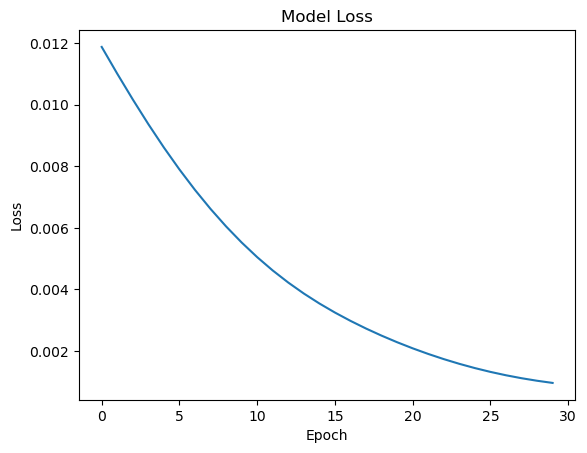

In [46]:
#'encoder' is our model and 'result' and 'result2' are our tensors

# Compile the model
encoder.compile(optimizer='adam', loss='mean_squared_error')

# Define the number of epochs
epochs = 30

# Initialize a list to store loss values
loss_history = []

# Training loop
for epoch in range(epochs):
    # Train on 'result' tensor
    history = encoder.fit(reduced_result, reduced_result, epochs=1, verbose=0)
    loss_history.append(history.history['loss'][0])
    
    # Train on 'result2' tensor
    #history = encoder.fit(result2, result2, epochs=1, verbose=0)
    #loss_history.append(history.history['loss'][0])
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_history[-1]:.8f}")

# Predict pixel values using the trained model
predicted_values = encoder.predict(reduced_result)

# Print final loss
print(f"Final loss: {loss_history[-1]:.8f}")

# You can plot the loss history if desired
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# Save the image using matplotlib.pyplot.imsave()
plt.savefig('modela06_loss_result1_1_30.png')
plt.show()

In [42]:
#predicted_values, pred_result
# calculates root mean squared error based on predicted tensor and unseen tensor

rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(predicted_values, reduced_predresult)
rmse.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.030473575>

### Reason for high RMSE
The model is overfitted to 1 day and compared with the unseen, next day. Training over 10-20 days would be better

## Plotting the results and the new data

### Plotting a slice visualization

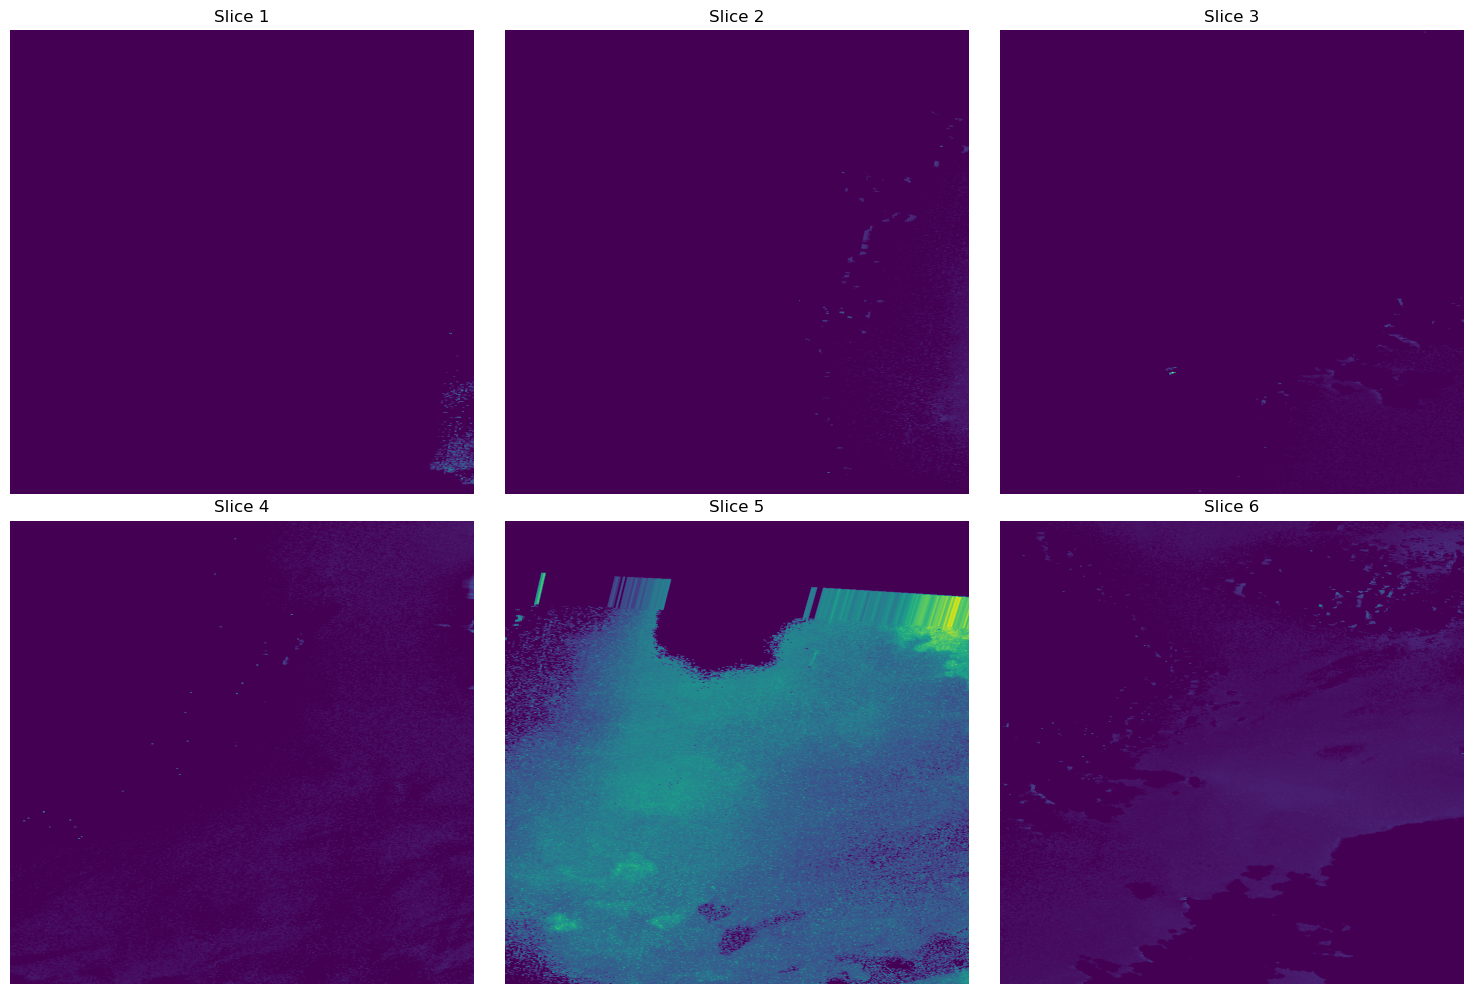

In [24]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(reduced_result[i, :, :, 0], cmap='viridis')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Plotting a SNS heatmap visualization

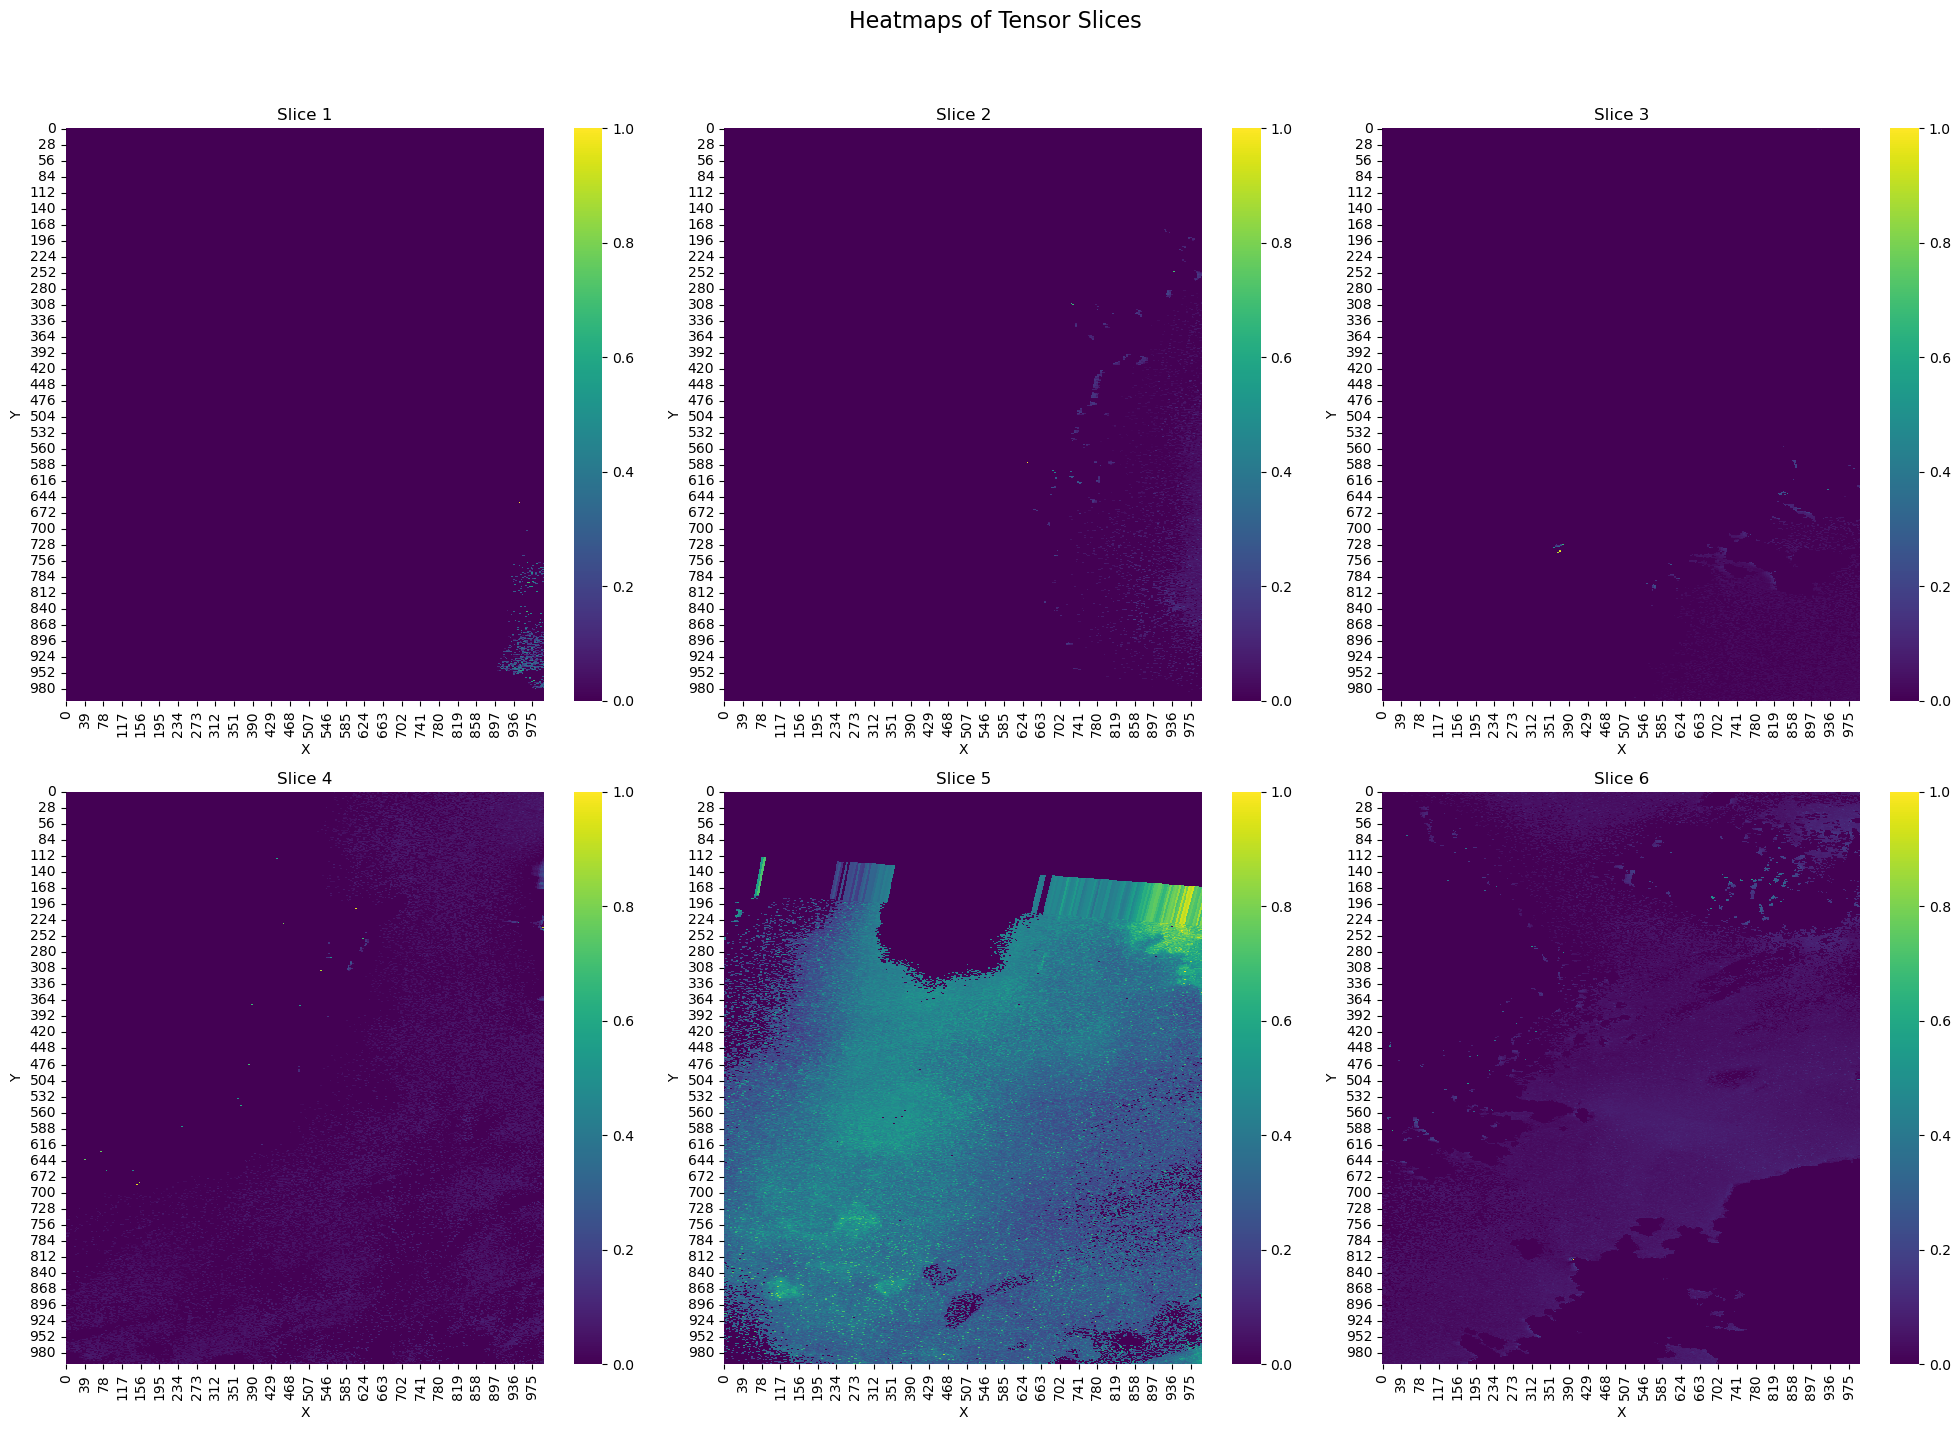

In [32]:
#plots a seaborn heatmap of the input tensor
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Heatmaps of Tensor Slices', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(reduced_result[i, :, :, 0], cmap='viridis', ax=ax, cbar=True)
    ax.set_title(f'Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
plt.show()

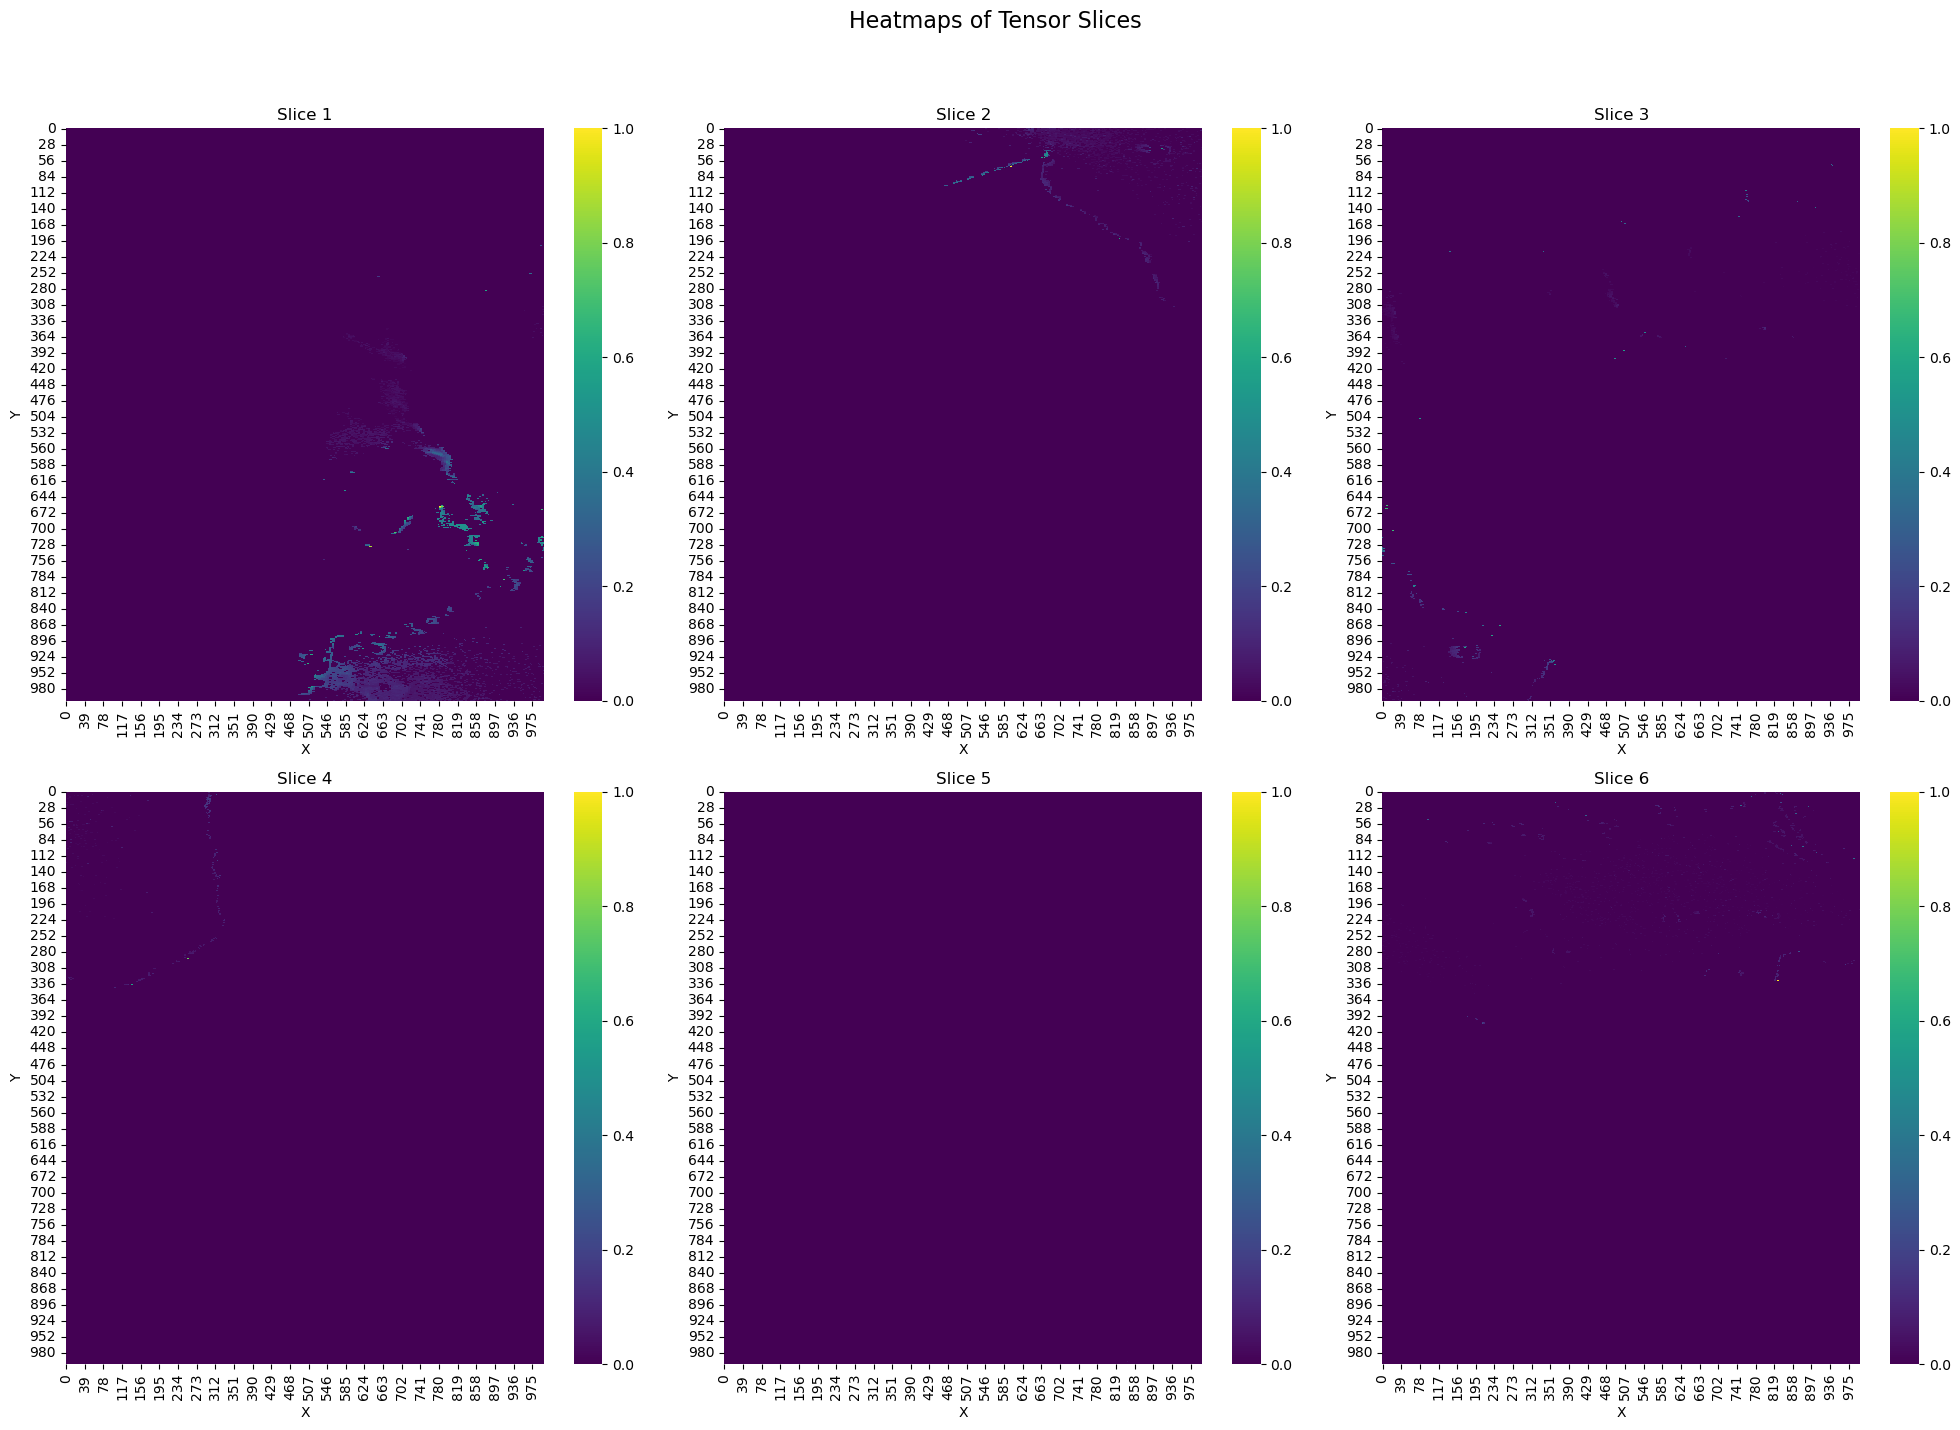

In [40]:
#plots a seaborn heatmap of the second input tensor
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Heatmaps of Tensor Slices', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(result2[i, :, :, 0], cmap='viridis', ax=ax, cbar=True)
    ax.set_title(f'Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
plt.show()

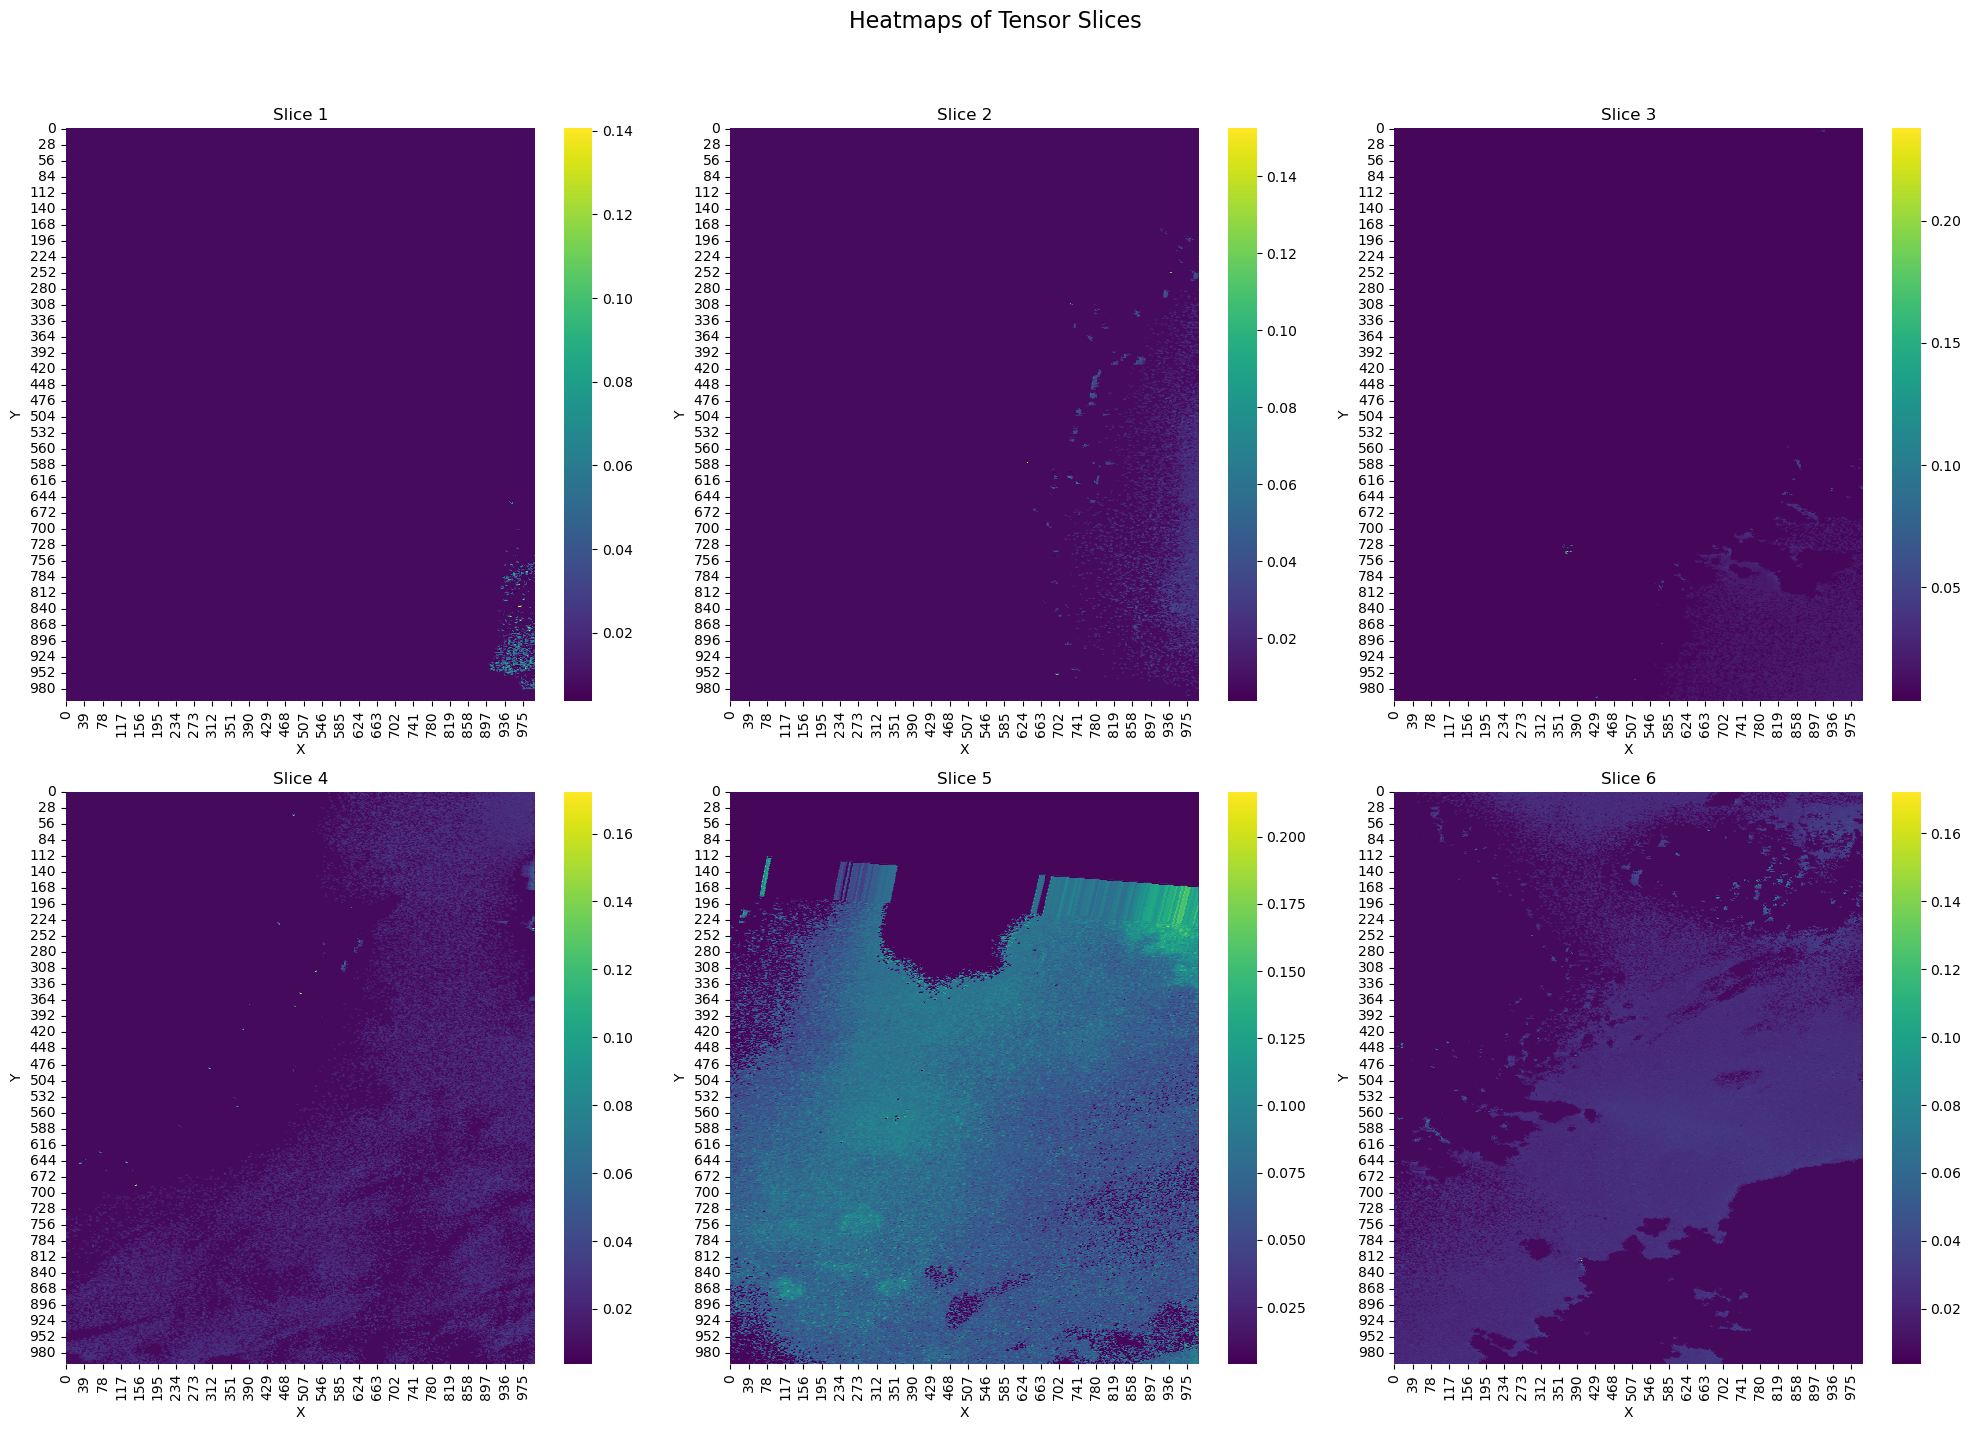

In [43]:
#plots a seaborn heatmap of the output tensor scaled to 0.0012 x \pi = 0.003768 as the threshold value

fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Heatmaps of Tensor Slices', fontsize=16)


for i, ax in enumerate(axes.flatten()):
    # Calculate the maximum value in the tensor slice
    vmax = np.max(predicted_values[i, :, :, 0])
    # Set vmin to 0.003768 and use the calculated vmax
    sns.heatmap(predicted_values[i, :, :, 0], cmap='viridis', vmin=0.003768, vmax=vmax, ax=ax, cbar=True)
    #sns.heatmap(predicted_values[i, :, :, 0], cmap='viridis', ax=ax, cbar=True)
    ax.set_title(f'Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
plt.show()

### Plots a 3D surface plot of the input \& predicted tensors


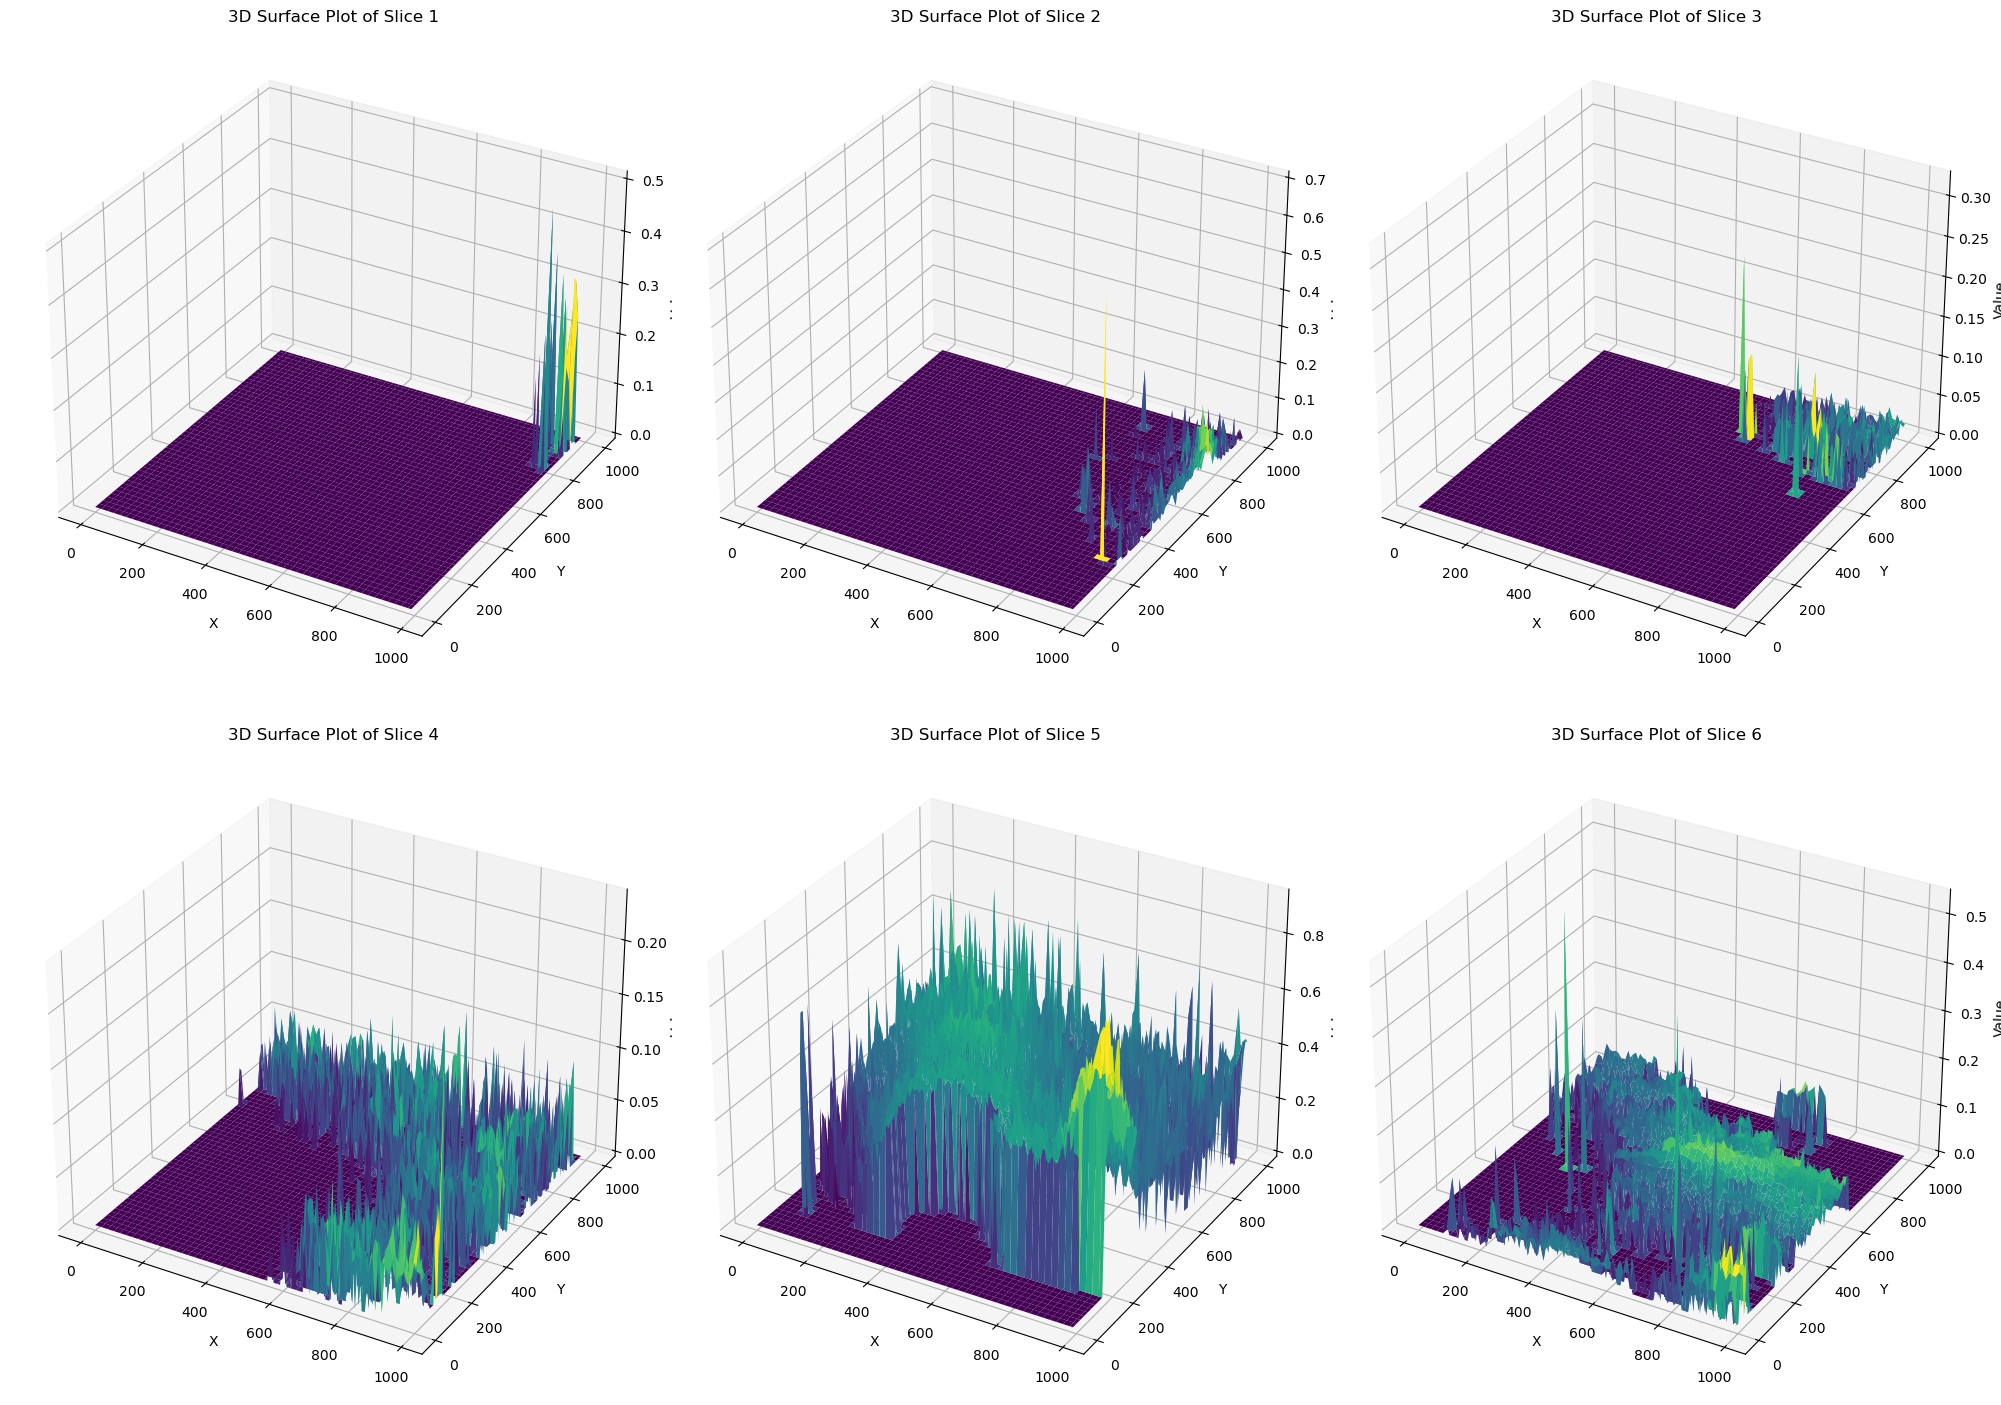

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    x, y = np.meshgrid(range(0, 1000, 10), range(0, 1000, 10))  # Downsampling for performance
    ax.plot_surface(x, y, reduced_result[i, ::10, ::10, 0], cmap='viridis')
    ax.set_title(f'3D Surface Plot of Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.show()

#fig = plt.figure(figsize=(12, 10))
#ax = fig.add_subplot(111, projection='3d')
#x, y = np.meshgrid(range(1000), range(1000))
#ax.plot_surface(x, y, result[0, :, :, 0], cmap='viridis')
#plt.title('3D Surface Plot of First Slice')
#plt.show()

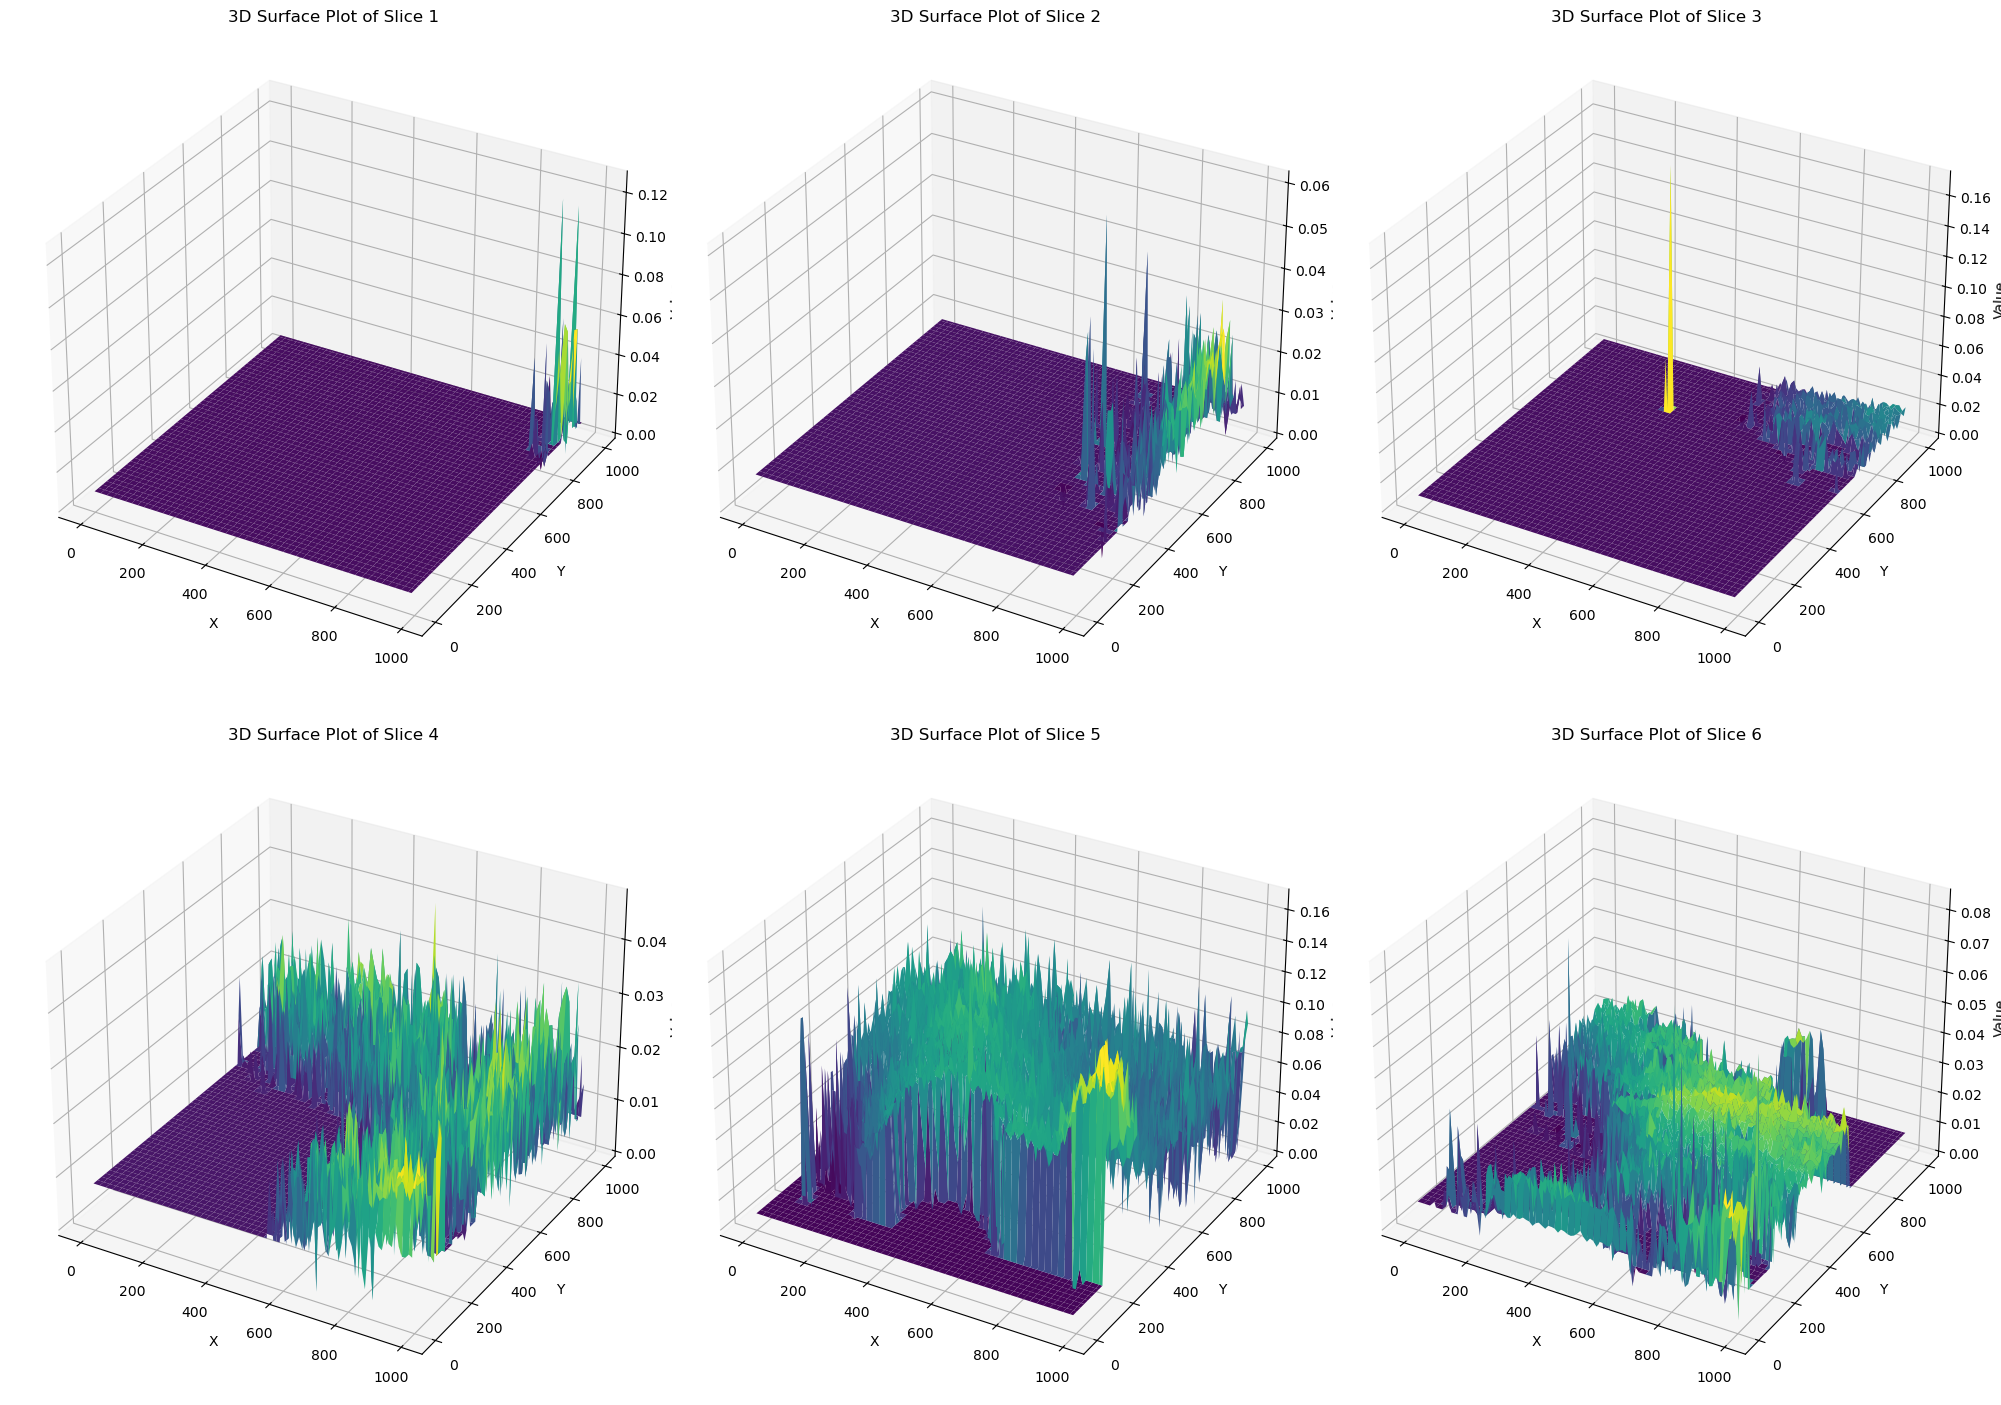

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

##Thresholds
##surface_TH = 0.0012 * np.pi (band for 665 nm)  ---> Oa08
##subsurface_TH = 0.00435 * np.pi * .9 (band for 560 nm) ---> Oa06


for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    x, y = np.meshgrid(range(0, 1000, 10), range(0, 1000, 10))  # Downsampling for performance
    ax.plot_surface(x, y, predicted_values[i, ::10, ::10, 0], cmap='viridis')
    ax.set_title(f'3D Surface Plot of Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.show()

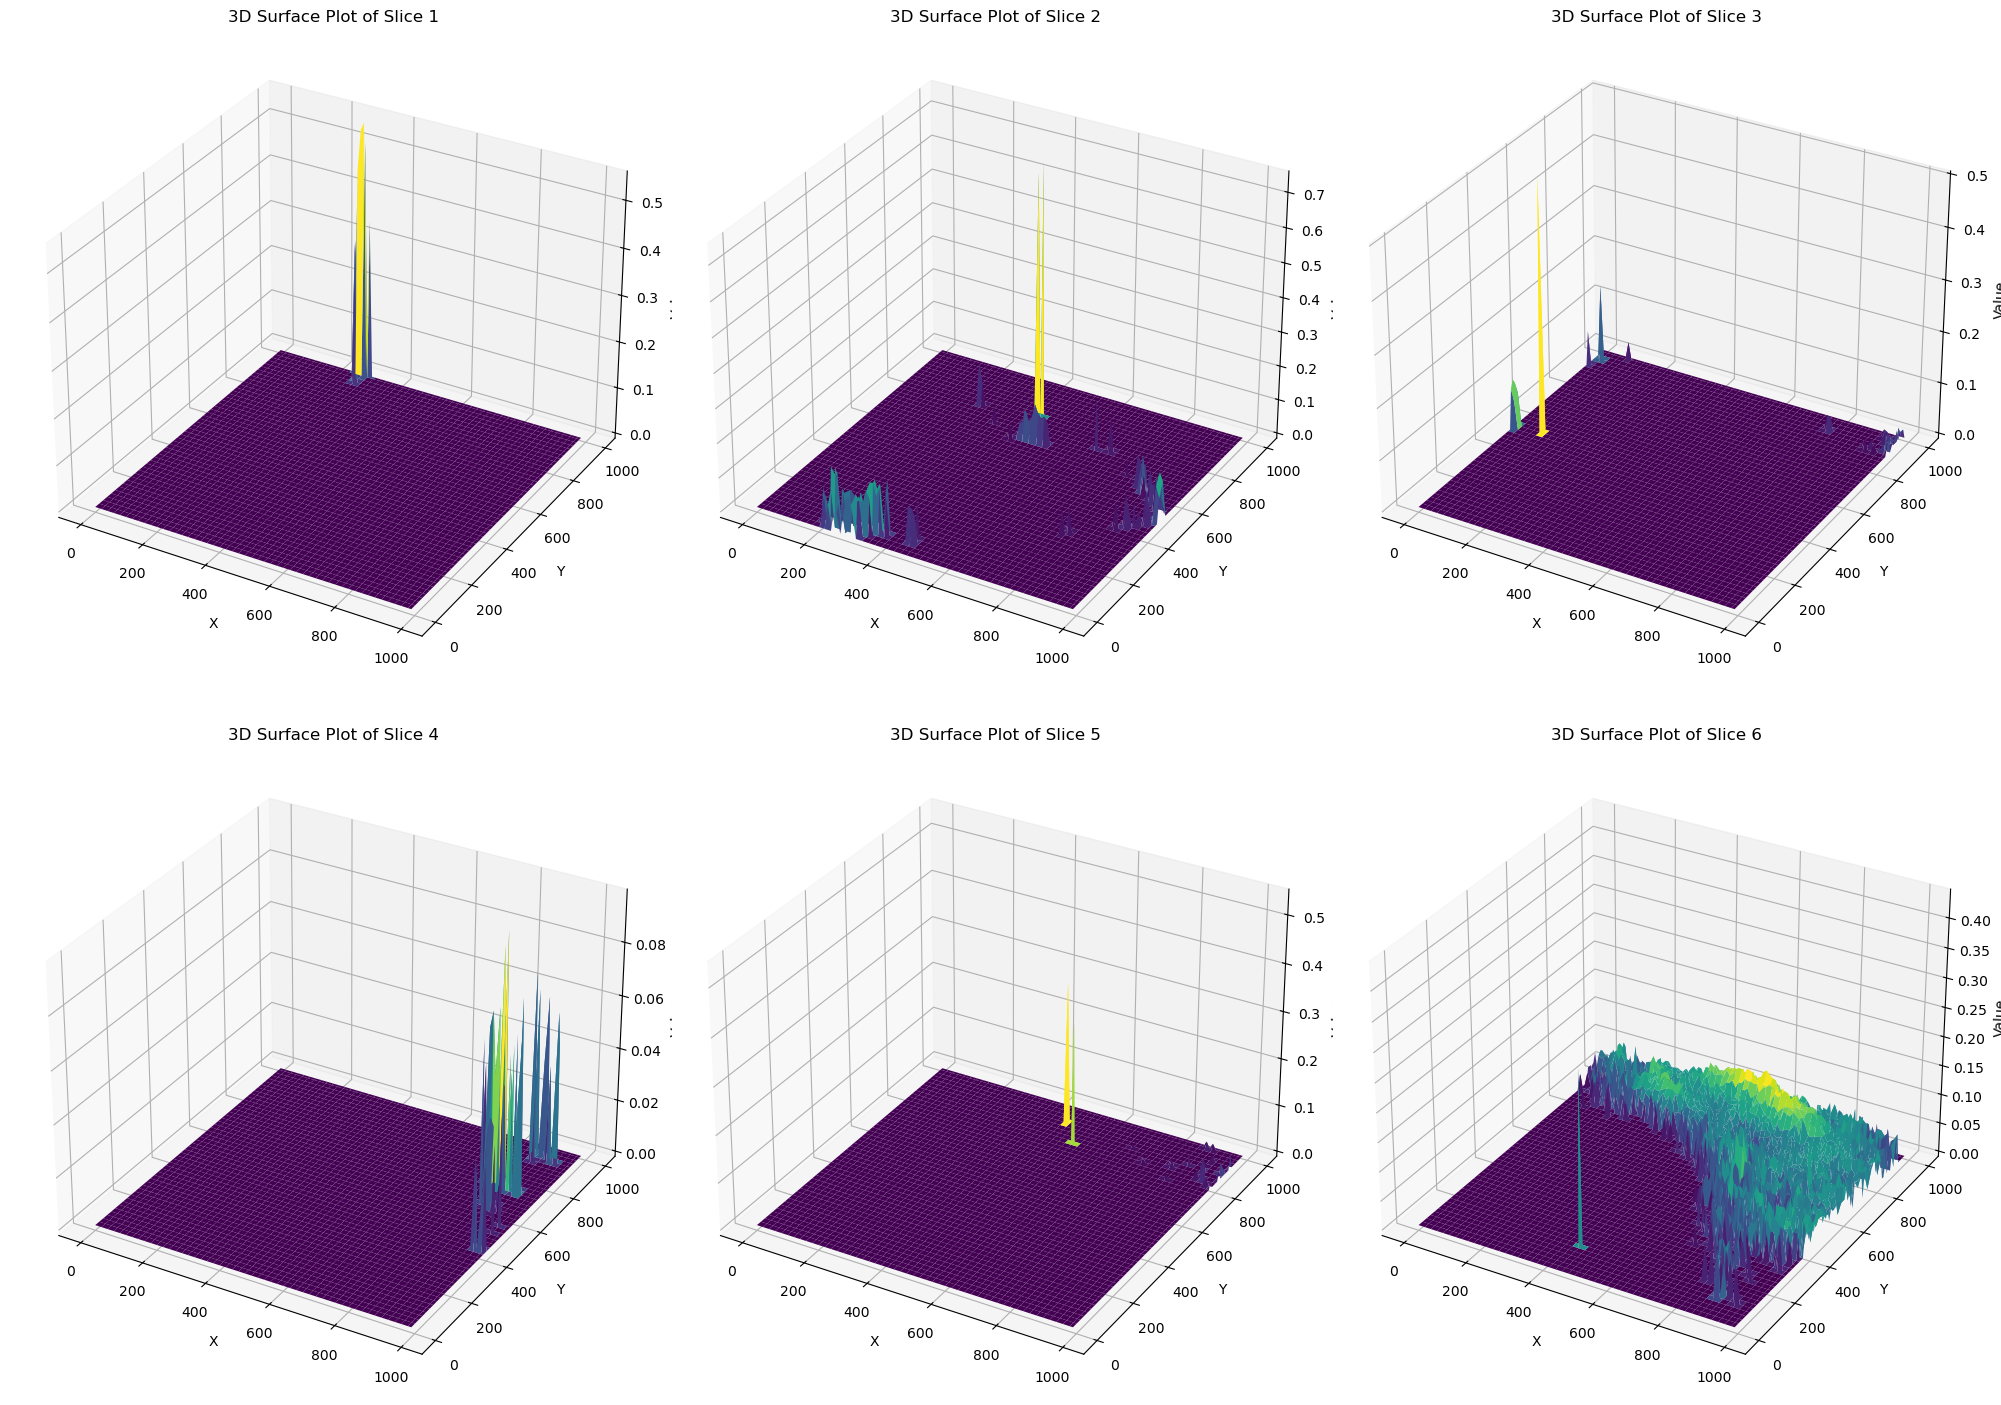

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

##Thresholds
##surface_TH = 0.0012 * np.pi (band for 665 nm)  ---> Oa08
##subsurface_TH = 0.00435 * np.pi * .9 (band for 560 nm) ---> Oa06


for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    x, y = np.meshgrid(range(0, 1000, 10), range(0, 1000, 10))  # Downsampling for performance
    ax.plot_surface(x, y, reduced_predresult[i, ::10, ::10, 0], cmap='viridis')
    ax.set_title(f'3D Surface Plot of Slice {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.show()